### This tutorial demostrate how to design a custom optimizer.

`Tim, Salimans, et al. "Weight normalization: a simple reparameterization to accelerate training of deep neural networks" 2016.`


In [1]:
# import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt
# set to plot in the notebook
%matplotlib inline 

# import keras (using tensorflow backend)
import keras

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
config.gpu_options.visible_device_list= '0'
set_session(tf.Session(config=config))

In [3]:
from keras.datasets import cifar10

# set batch size and number of classes
input_shape = (32,32,3)
batch_size = 500
num_classes = 10
epochs = 10

# load cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# convert class vectors to one-hot binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# normalize data to [-1, 1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 127.5
x_test /= 127.5
x_train -= 1.
x_test -= 1.

In [4]:
from keras.models import Sequential

from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D

def cnn_model(input_shape, num_classes):    
    model = Sequential()

    # conv1
    model.add(Conv2D(32, (3, 3), padding='valid', input_shape=input_shape))
    model.add(Activation('relu'))
    # pool1
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))

    # conv2
    model.add(Conv2D(64, (3, 3), padding='valid'))
    model.add(Activation('relu'))
    # pool2
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))

    # fc1
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation('relu'))

    # fc2
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

model = cnn_model(input_shape, num_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
activation_2 (Activation)    (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

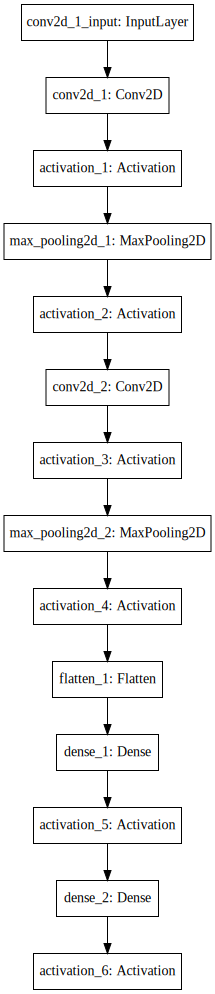

In [5]:
# show model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# or you can save model diagram by following code
#from keras.utils import plot_model
#plot_model(model, to_file='cnn_model.png')

In [6]:
from keras import backend as K
from keras.optimizers import Adam

# adapted from keras.optimizers.Adam
class custom_optimizer(Adam):
    def get_updates(self, params, loss):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * tf.cast(self.iterations, tf.float32)))

        t = tf.cast(self.iterations, tf.float32) + 1
        lr_t = lr * K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t))

        shapes = [K.get_variable_shape(p) for p in params]
        ms = [K.zeros(shape) for shape in shapes]
        vs = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):

            # if a weight tensor (len > 1) use weight normalized parameterization
            ps = K.get_variable_shape(p)
            if len(ps)>1:

                # get weight normalization parameters
                V, V_norm, V_scaler, g_param, grad_g, grad_V = get_custom_params_and_grads(p, g)

                # Adam containers for the 'g' parameter
                V_scaler_shape = K.get_variable_shape(V_scaler)
                m_g = K.zeros(V_scaler_shape)
                v_g = K.zeros(V_scaler_shape)

                # update g parameters
                m_g_t = (self.beta_1 * m_g) + (1. - self.beta_1) * grad_g
                v_g_t = (self.beta_2 * v_g) + (1. - self.beta_2) * K.square(grad_g)
                new_g_param = g_param - lr_t * m_g_t / (K.sqrt(v_g_t) + self.epsilon)
                self.updates.append(K.update(m_g, m_g_t))
                self.updates.append(K.update(v_g, v_g_t))

                # update V parameters
                m_t = (self.beta_1 * m) + (1. - self.beta_1) * grad_V
                v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(grad_V)
                new_V_param = V - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)
                self.updates.append(K.update(m, m_t))
                self.updates.append(K.update(v, v_t))

                # wn param updates --> W updates
                add_custom_param_updates(self.updates, new_V_param, new_g_param, p, V_scaler)

            else: # do optimization normally
                m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
                v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
                p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

                self.updates.append(K.update(m, m_t))
                self.updates.append(K.update(v, v_t))

                new_p = p_t
                #new_p = K.clip(new_p,-1.,1.)
                
                self.updates.append(K.update(p, new_p))
        return self.updates
    
def get_custom_params_and_grads(p, g):
    ps = K.get_variable_shape(p)

    # construct weight scaler: V_scaler = g/||V||
    V_scaler_shape = (ps[-1],)  # assumes we're using tensorflow!
    V_scaler = K.ones(V_scaler_shape)  # init to ones, so effective parameters don't change

    # get V parameters = ||V||/g * W
    norm_axes = [i for i in range(len(ps) - 1)]
    V = p / tf.reshape(V_scaler, [1] * len(norm_axes) + [-1])

    # split V_scaler into ||V|| and g parameters
    V_norm = tf.sqrt(tf.reduce_sum(tf.square(V), norm_axes))
    g_param = V_scaler * V_norm

    # get grad in V,g parameters
    grad_g = tf.reduce_sum(g * V, norm_axes) / V_norm
    grad_V = tf.reshape(V_scaler, [1] * len(norm_axes) + [-1]) * \
             (g - tf.reshape(grad_g / V_norm, [1] * len(norm_axes) + [-1]) * V)

    return V, V_norm, V_scaler, g_param, grad_g, grad_V


def add_custom_param_updates(updates, new_V_param, new_g_param, W, V_scaler):
    ps = K.get_variable_shape(new_V_param)
    norm_axes = [i for i in range(len(ps) - 1)]

    # update W and V_scaler
    new_V_norm = tf.sqrt(tf.reduce_sum(tf.square(new_V_param), norm_axes))
    new_V_scaler = new_g_param / new_V_norm
    new_W = tf.reshape(new_V_scaler, [1] * len(norm_axes) + [-1]) * new_V_param
    #new_W = K.clip(new_W,-1.,1.)
    
    updates.append(K.update(W, new_W))
    updates.append(K.update(V_scaler, new_V_scaler))
    
optimizer = custom_optimizer()

# compile model
loss = keras.losses.categorical_crossentropy
metric = keras.metrics.categorical_accuracy
model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

# import image data generator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

# Compute quantities required for feature-wise normalization
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test))

Epoch 1/10
100/100 [==============================] - 3s 26ms/step - loss: 1.6251 - categorical_accuracy: 0.4227 - val_loss: 1.3572 - val_categorical_accuracy: 0.5211
Epoch 2/10
100/100 [==============================] - 2s 17ms/step - loss: 1.2700 - categorical_accuracy: 0.5544 - val_loss: 1.2177 - val_categorical_accuracy: 0.5656
Epoch 3/10
100/100 [==============================] - 2s 16ms/step - loss: 1.1356 - categorical_accuracy: 0.6043 - val_loss: 1.1058 - val_categorical_accuracy: 0.6116
Epoch 4/10
100/100 [==============================] - 2s 15ms/step - loss: 1.0451 - categorical_accuracy: 0.6362 - val_loss: 1.0827 - val_categorical_accuracy: 0.6206
Epoch 5/10
100/100 [==============================] - 2s 15ms/step - loss: 0.9816 - categorical_accuracy: 0.6600 - val_loss: 1.0072 - val_categorical_accuracy: 0.6492
Epoch 6/10
100/100 [==============================] - 2s 15ms/step - loss: 0.9246 - categorical_accuracy: 0.6812 - val_loss: 0.9668 - val_categorical_accuracy: 0.665

In [7]:
[train_loss, train_acc] = history.model.evaluate(x=x_train, y=y_train, batch_size=batch_size, verbose=0)
print("Train accuracy:{0:.2f}%.".format(train_acc*100))

Train accuracy:73.89%.


In [8]:
[test_loss, test_acc] = history.model.evaluate(x=x_test, y=y_test, batch_size=batch_size, verbose=0)
print("Test accuracy:{0:.2f}%.".format(test_acc*100))

Test accuracy:68.29%.
